<a href="https://colab.research.google.com/github/ktw-98/Portfolio/blob/main/MAP_based_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 프로세스 노이즈, 측정 노이즈 최소화하기
$$
\begin{aligned}
  \underset{x,w,v}{\min} \quad & \sum_{t=0}^{N-1} \|w_t\|^2 + \tau\|n_t\|^2   \\
  \text{subject to} \quad & x_{t+1} = Ax_t + Bw_t\\
  & y_t = Cx_t + n_t, \qquad t=0,\dots,N-1 \
\end{aligned}
$$


In [110]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm

## 1. 운동방정식 세우기

1.1
$t\in \{0,\dots,N-1\}$ 에서 운동방정식
$$
\begin{aligned}
  x_{t+1} &= Ax_t + w_t \\
  y_{t} &= Cx_t + v_t   
\end{aligned} \
$$


$$
A =
\begin{bmatrix}
1 & 0 & \left(1 - \frac{\gamma \Delta t}{2}\right)\Delta t & 0 \\
0 & 1 & 0 & \left(1 - \frac{\gamma \Delta t}{2}\right)\Delta t \\
0 & 0 & 1 - \gamma \Delta t & 0 \\
0 & 0 & 0 & 1 - \gamma \Delta t
\end{bmatrix}
$$

  


$$
B =
\begin{bmatrix}
\frac{\Delta t^2}{2} & 0 \\
0 & \frac{\Delta t^2}{2} \\
\Delta t & 0 \\
0 & \Delta t
\end{bmatrix}
$$

$$
C =
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0
\end{bmatrix}
$$

In [111]:
N = 200 # number of timesteps
T = 100 # time will vary from 0 to T with step delt
ts = np.linspace(0,T,N+1)
delt = T/N
gamma = 0.05 # damping, 0 is no damping

A = np.zeros((4,4))
B = np.zeros((4,2))
C = np.zeros((2,4))

A[0,0] = 1
A[1,1] = 1
A[0,2] = (1-gamma*delt/2)*delt
A[1,3] = (1-gamma*delt/2)*delt
A[2,2] = 1 - gamma*delt
A[3,3] = 1 - gamma*delt

B[0,0] = delt**2/2
B[1,1] = delt**2/2
B[2,0] = delt
B[3,1] = delt

C[0,0] = 1
C[1,1] = 1


1.2 Q, R 설정

$$
Q=
\mathbb{E}\!\left(w_t w_t^{T}\right)
=
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

$$
R=
\mathbb{E}\!\left(n_t n_t^{T}\right)
=
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
$$

1.3 궤적 생성
$$
  x_{t+1} = A @ x_t + B @ w_t \\
  y_t = C @ x_t + n_t
$$

In [112]:
np.random.seed(11)

x = np.zeros((4,N+1))
x[:,0] = [0,0,0,0]
y = np.zeros((2,N))

Q = np.diag([1,1])
R = np.diag([1,1])
Qh = sqrtm(Q)
Rh = sqrtm(R)

w = Qh@np.random.randn(2,N)
n = Rh@np.random.randn(2,N)

for t in range(N):
    x[:,t+1] = A.dot(x[:,t]) + B.dot(w[:,t])
    y[:,t]   = C.dot(x[:,t]) + n[:,t]

x_true = x.copy()
w_true = w.copy()
n_true = n.copy()


1.4 시각화

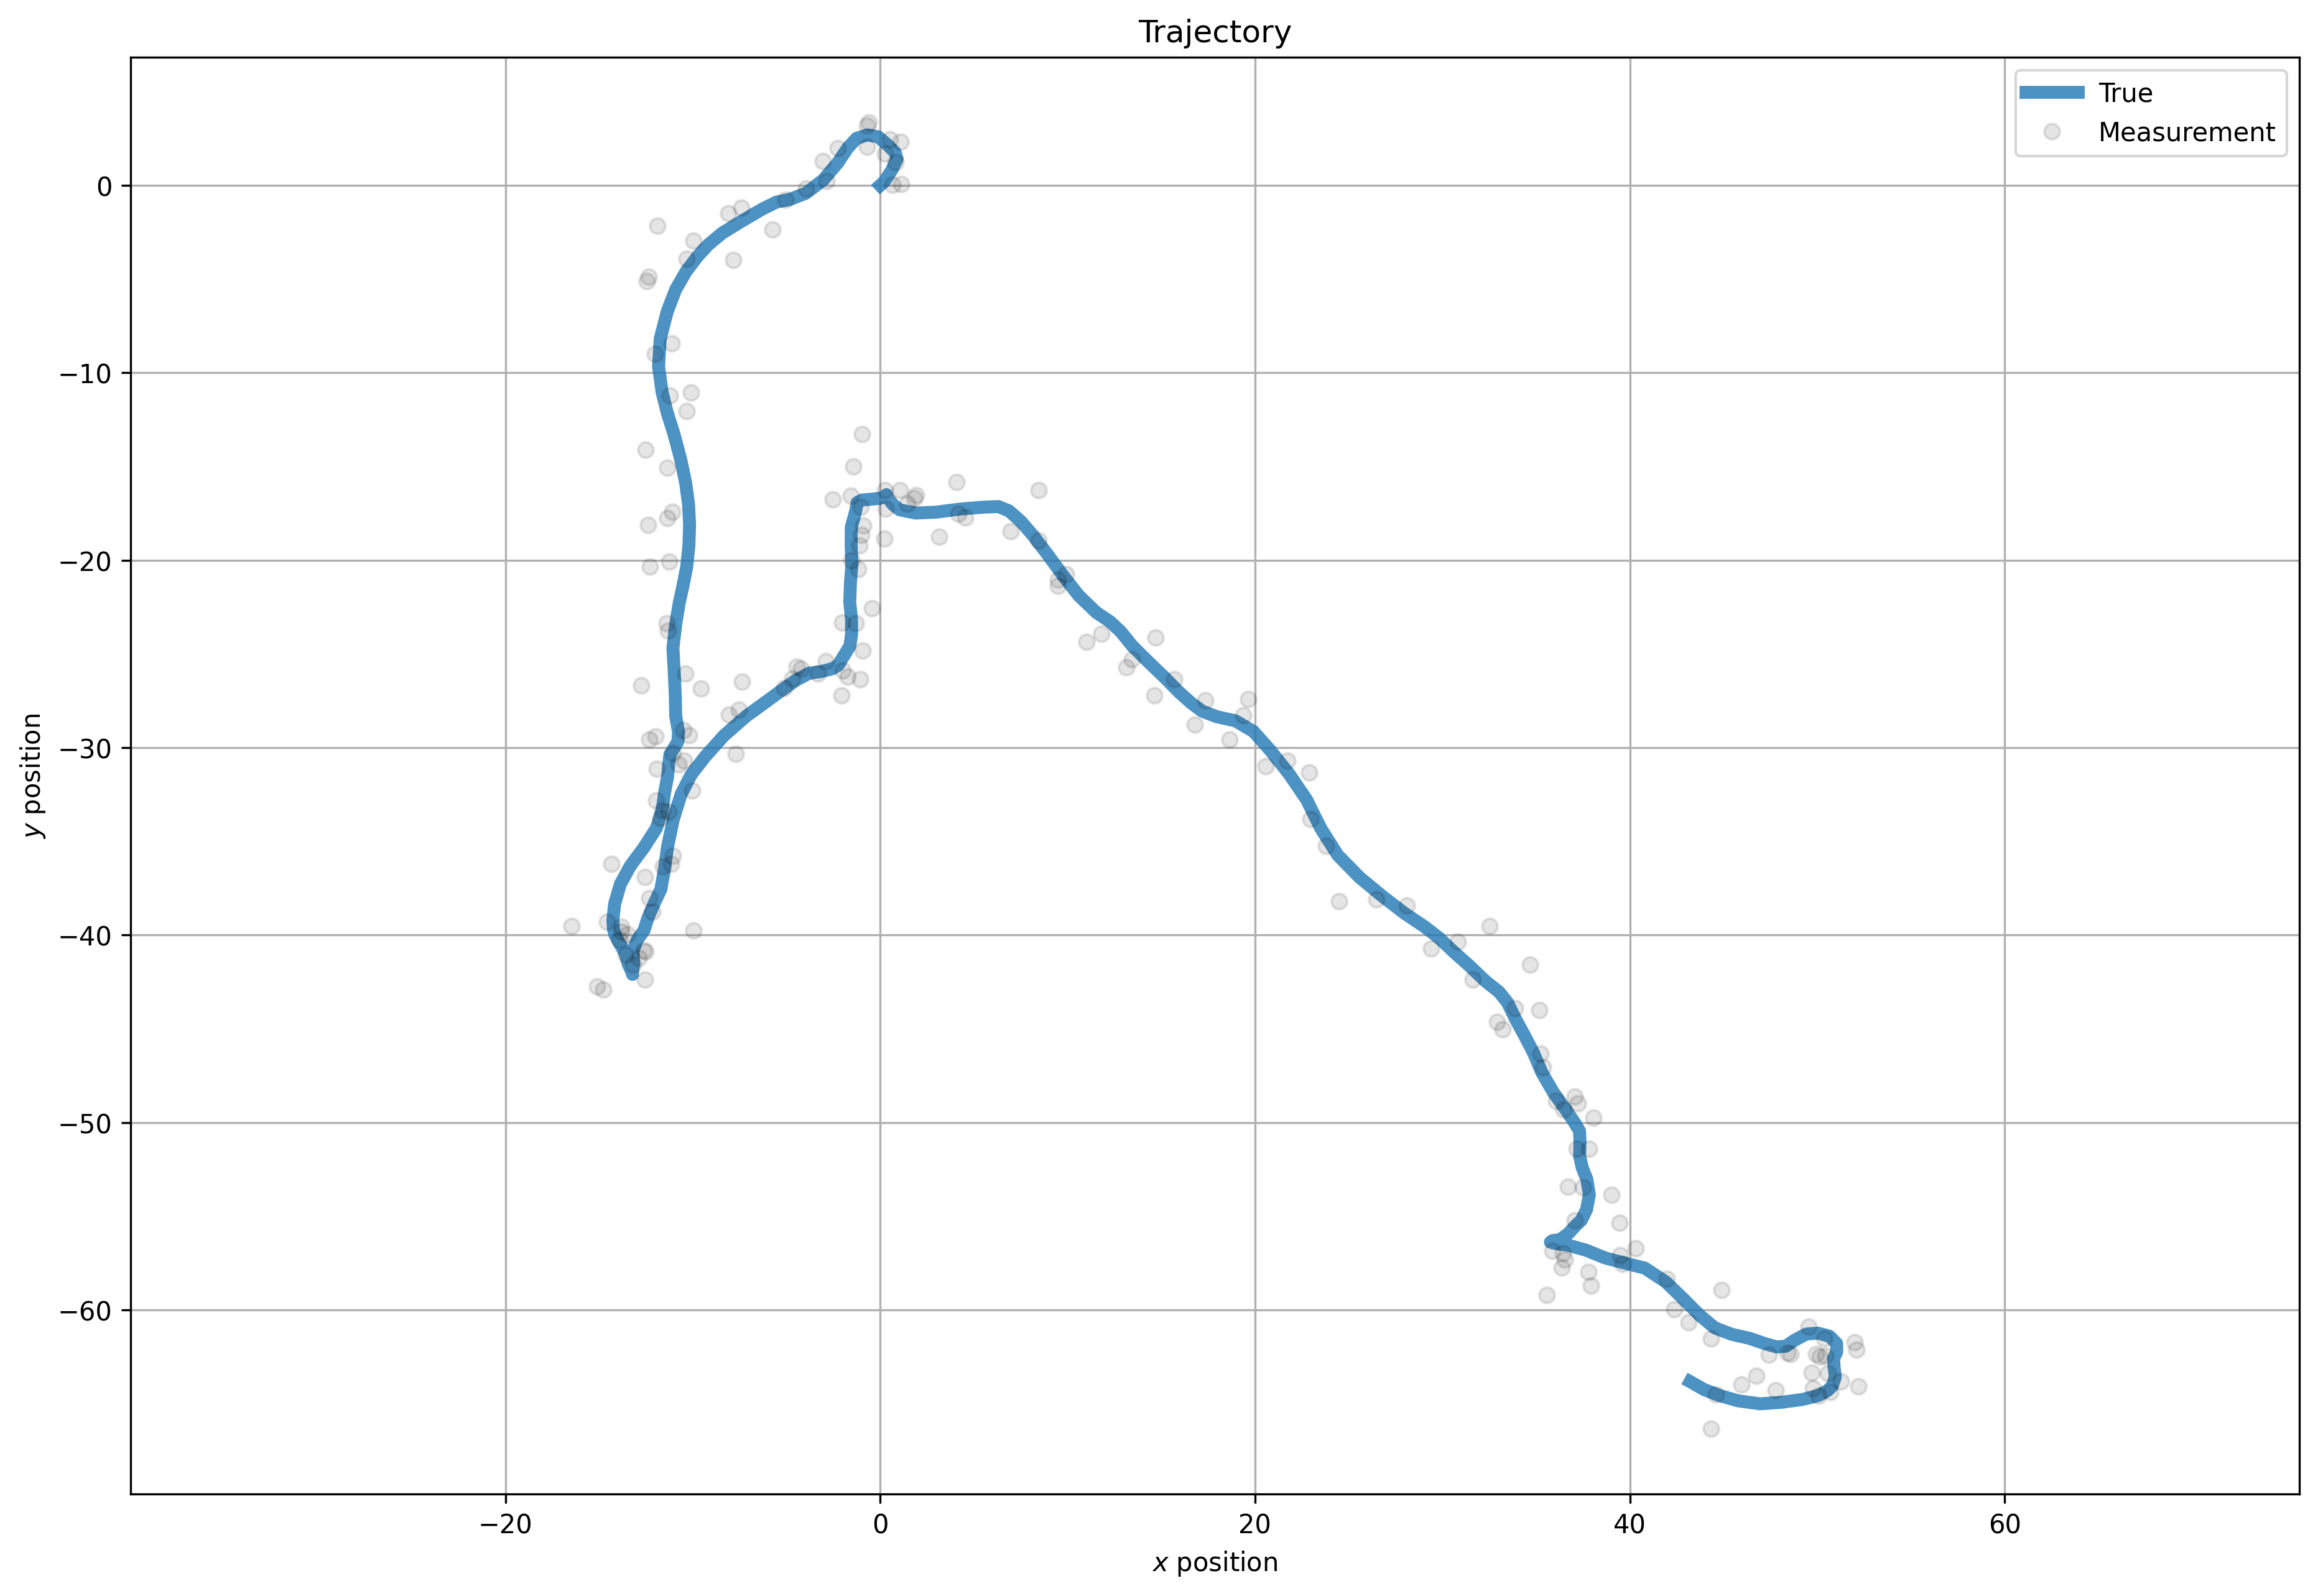

In [113]:
plt.figure(figsize=(15,10), dpi=300)
plt.plot(x[0,:],x[1,:],'-',alpha=0.8, linewidth=5, label='True')
plt.plot(y[0,:],y[1,:],'ko',alpha=0.1, label='Measurement')
plt.title('Trajectory')
plt.grid()
plt.legend()
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.axis('equal')
plt.show()

## 2. LS 최적화

2.1 cp로 최적화 풀기

In [114]:
import cvxpy as cp

x = cp.Variable(shape=(4, N+1))
w = cp.Variable(shape=(2, N))
n = cp.Variable(shape=(2, N))

tau = 0.16

obj = cp.sum_squares(w) + tau*cp.sum_squares(n)
obj = cp.Minimize(obj)

constr = []
for t in range(N):
    constr += [ x[:,t+1] == A@x[:,t] + B@w[:,t] ,
                y[:,t]   == C@x[:,t] + n[:,t]   ]

cp.Problem(obj, constr).solve(verbose=True)

x_kf = np.array(x.value)
w_kf = np.array(w.value)
n_kf = np.array(n.value)


(CVXPY) Jan 04 07:28:16 AM: Your problem has 1604 variables, 1200 constraints, and 0 parameters.
(CVXPY) Jan 04 07:28:16 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 04 07:28:16 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 04 07:28:16 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 04 07:28:16 AM: Your problem is compiled with the CPP canonicalization backend.


                                     CVXPY                                     
                                     v1.6.7                                    


(CVXPY) Jan 04 07:28:16 AM: Compiling problem (target solver=OSQP).
(CVXPY) Jan 04 07:28:16 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Jan 04 07:28:16 AM: Applying reduction CvxAttr2Constr
(CVXPY) Jan 04 07:28:16 AM: Applying reduction Qp2SymbolicQp


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jan 04 07:28:16 AM: Applying reduction QpMatrixStuffing
(CVXPY) Jan 04 07:28:17 AM: Applying reduction OSQP
(CVXPY) Jan 04 07:28:17 AM: Finished problem compilation (took 1.000e+00 seconds).
(CVXPY) Jan 04 07:28:17 AM: Invoking solver OSQP  to obtain a solution.
(CVXPY) Jan 04 07:28:17 AM: Problem status: optimal
(CVXPY) Jan 04 07:28:17 AM: Optimal value: 9.073e+01
(CVXPY) Jan 04 07:28:17 AM: Compilation took 1.000e+00 seconds
(CVXPY) Jan 04 07:28:17 AM: Solver (including time spent in interface) took 1.861e-02 seconds


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-----------------------------------------------------------------
           OSQP v1.0.0  -  Operator Splitting QP Solver
              (c) The OSQP Developer Team
-----------------------------------------------------------------
problem:  variables n = 1604, constraints m = 1200
          nnz(P) + nnz(A) = 4400
settings: algebra = Built-in,
          OSQPInt = 4 bytes, OSQPFloat = 8 bytes,
          linear system solver = QDLDL v0.1.8,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive: 50 iterations),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25, duality gap: on),
          time_limit: 1.00e+10 sec,
  

2.2 시각화

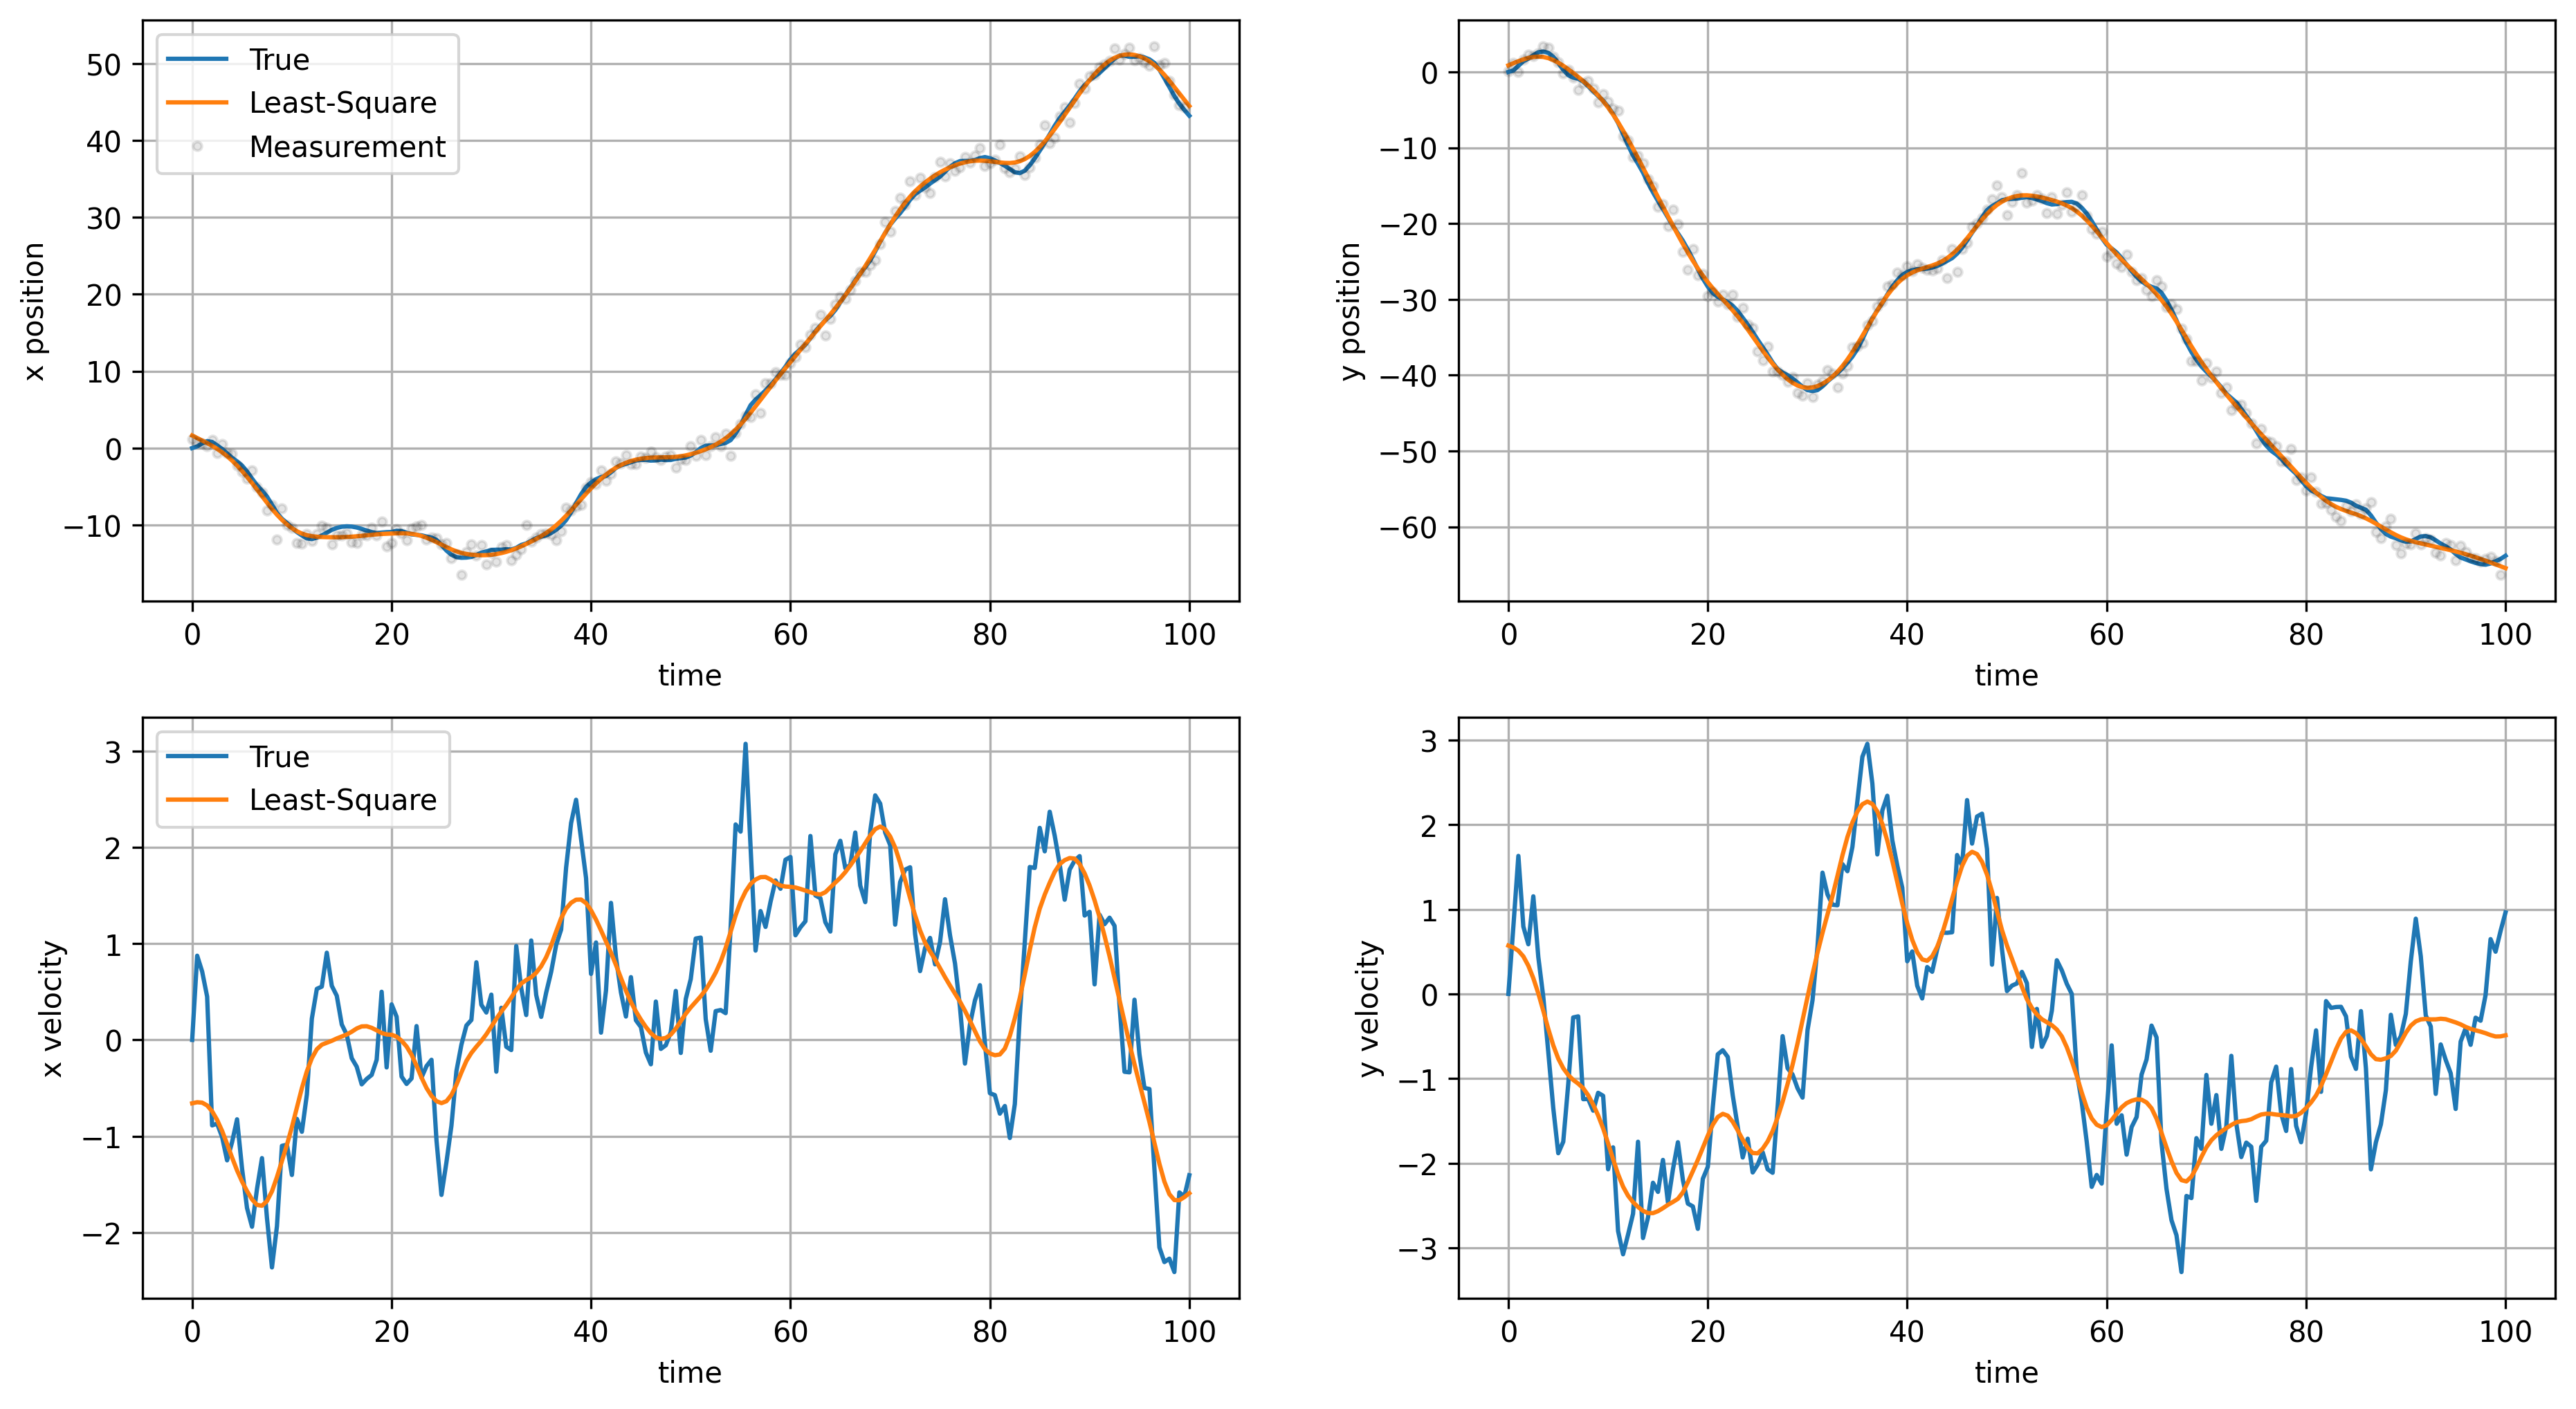

In [115]:
plt.figure(figsize=(15,8), dpi=300)
plt.subplot(2,2,1)
plt.plot(ts,x_true[0,:], label='True')
plt.plot(ts,x_kf[0,:], label='Least-Square')
plt.plot(ts[:-1],y[0,:], 'k.', alpha=0.1, label='Measurement')
plt.xlabel('time')
plt.ylabel('x position')
plt.legend()
plt.grid()
plt.subplot(2,2,2)
plt.plot(ts,x_true[1,:])
plt.plot(ts,x_kf[1,:])
plt.plot(ts[:-1],y[1,:], 'k.', alpha=0.1)
plt.xlabel('time')
plt.ylabel('y position')
plt.grid()
plt.subplot(2,2,3)
plt.plot(ts,x_true[2,:], label='True')
plt.plot(ts,x_kf[2,:], label='Least-Square')
plt.xlabel('time')
plt.ylabel('x velocity')
plt.legend()
plt.grid()
plt.subplot(2,2,4)
plt.plot(ts,x_true[3,:])
plt.plot(ts,x_kf[3,:])
plt.xlabel('time')
plt.ylabel('y velocity')
plt.grid()
plt.show()


## 3. 재귀 칼만필터로 풀기

3.1 재귀 업데이트 식 세우기

In [116]:
Sigma_w = B @ Q @ B.T         # 상태 잡음 공분산
Sigma_v = R                   # 측정 잡음 공분산
P = np.eye(4)

x_rk = np.zeros((4,N+1))
w_rk = np.zeros((4,N))
n_rk = np.zeros((2,N))
x_rk[:,0] = np.array([0,0,0,0])

I = np.eye(4)

for t in range(N):
    # 1) Predict
    x_pred = A @ x_rk[:,t]
    P_pred = A @ P @ A.T + Sigma_w

    # 2) Kalman gain
    S = C @ P_pred @ C.T + Sigma_v              # (2x2)
    K = P_pred @ C.T @ np.linalg.inv(S)         # (4x2)

    # 3) Update
    innov = y[:,t] - C @ x_pred                 # (2,)
    x_rk[:,t+1] = x_pred + K @ innov            # (4,)
    P = (I - K @ C) @ P_pred                    # (4x4)

    # residuals (추정된 것들)
    w_rk[:,t] = x_rk[:,t+1] - A @ x_rk[:,t]     # (4,)
    n_rk[:,t] = y[:,t] - C @ x_rk[:,t]          # (2,)



3.2 시각화

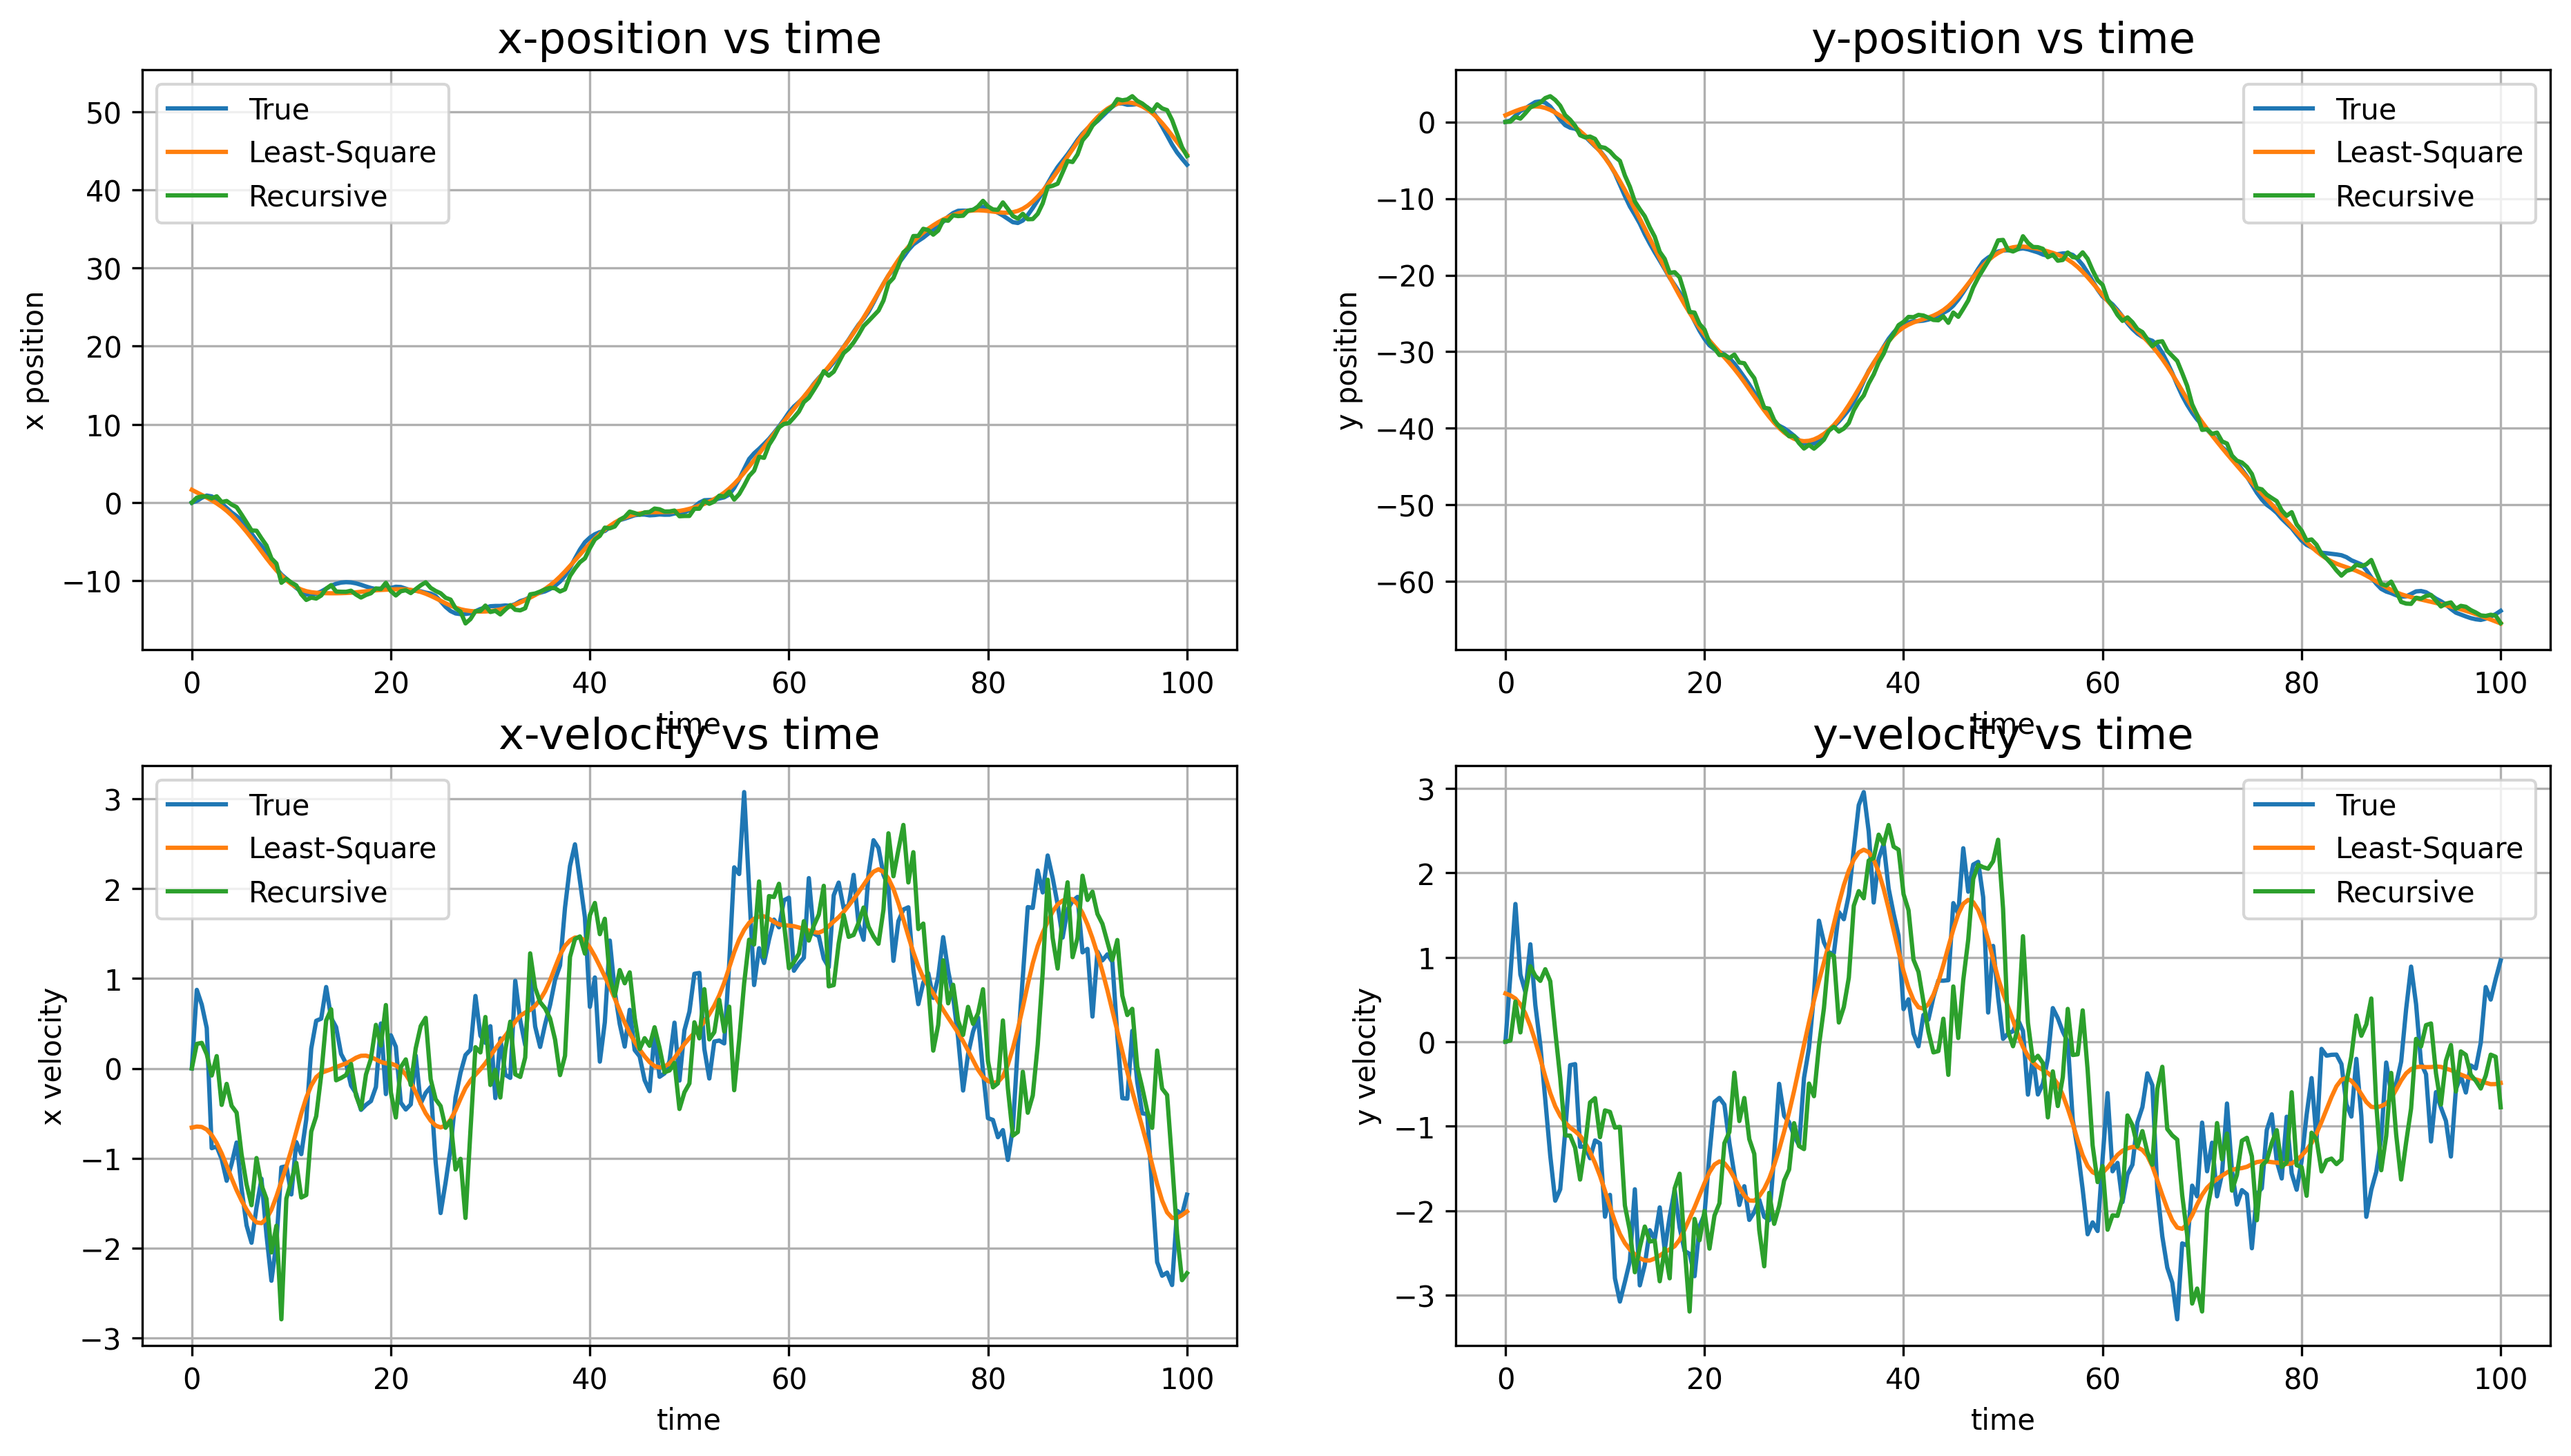

In [117]:
plt.figure(figsize=(15,8), dpi=300)
plt.subplot(2,2,1)
plt.plot(ts, x_true[0,:], label='True')
plt.plot(ts, x_kf[0,:], label='Least-Square')
plt.plot(ts, x_rk[0,:], label='Recursive')
plt.xlabel('time')
plt.ylabel('x position')
plt.title('x-position vs time', fontsize=15)
plt.legend(); plt.grid()

plt.subplot(2,2,2)
plt.plot(ts, x_true[1,:], label='True')
plt.plot(ts, x_kf[1,:], label='Least-Square')
plt.plot(ts, x_rk[1,:], label='Recursive')
plt.xlabel('time')
plt.ylabel('y position')
plt.title('y-position vs time', fontsize=15)
plt.legend(); plt.grid()

plt.subplot(2,2,3)
plt.plot(ts, x_true[2,:], label='True')
plt.plot(ts, x_kf[2,:], label='Least-Square')
plt.plot(ts, x_rk[2,:], label='Recursive')
plt.xlabel('time')
plt.ylabel('x velocity')
plt.title('x-velocity vs time', fontsize=15)
plt.legend(); plt.grid()

plt.subplot(2,2,4)
plt.plot(ts, x_true[3,:], label='True')
plt.plot(ts, x_kf[3,:], label='Least-Square')
plt.plot(ts, x_rk[3,:], label='Recursive')
plt.xlabel('time')
plt.ylabel('y velocity')
plt.title('y-velocity vs time', fontsize=15)
plt.legend(); plt.grid()

plt.show()


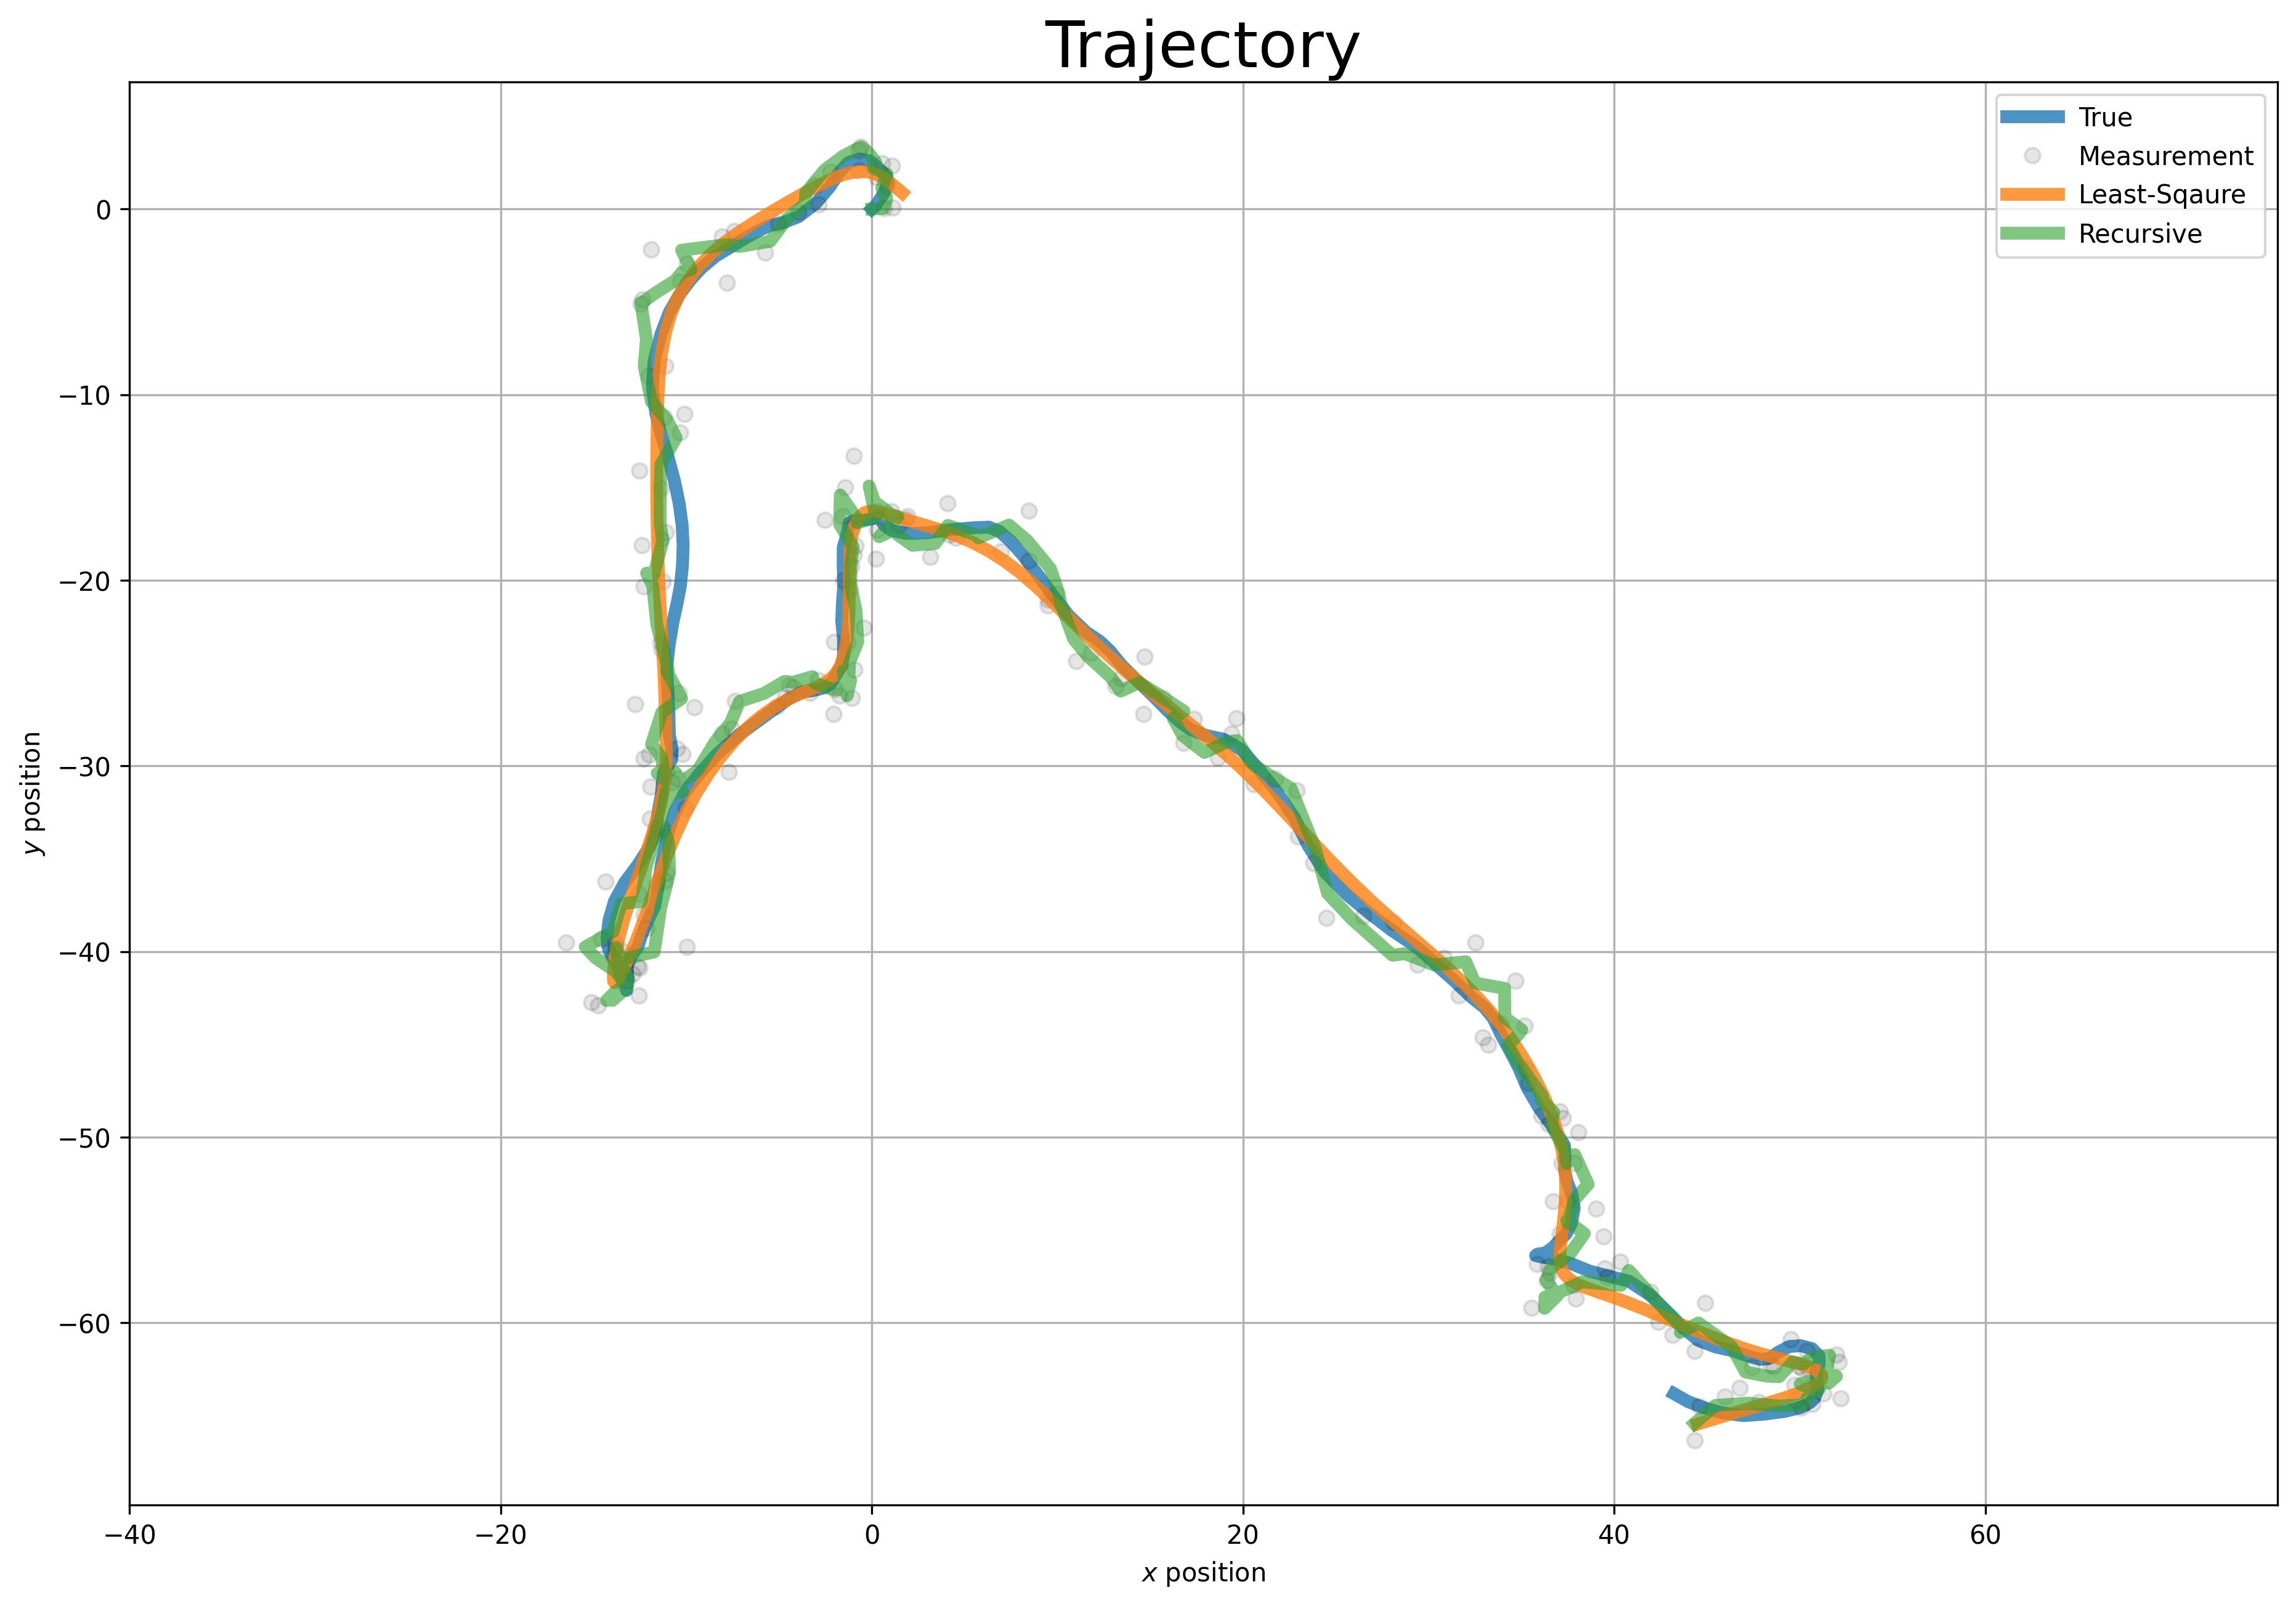

In [118]:
plt.figure(figsize=(15,10), dpi=300)
plt.plot(x_true[0,:],x_true[1,:],'-',alpha=0.8, linewidth=5, label='True')
plt.plot(y[0,:],y[1,:],'ko',alpha=0.1, label='Measurement')
plt.plot(x_kf[0,:],x_kf[1,:],'-',alpha=0.8, linewidth=5, label='Least-Sqaure')
plt.plot(x_rk[0,:],x_rk[1,:],'-',alpha=0.6, linewidth=5, label='Recursive')
plt.title('Trajectory', fontsize=25)
plt.grid()
plt.legend()
plt.xlabel(r'$x$ position')
plt.ylabel(r'$y$ position')
plt.axis('equal')
plt.show()
